### Calibration of wave gauge with temperature compensation ###

See other version in D:\Work\_Python3\And0K\tcm_cnv!

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import sys
try:
    from ruamel.yaml import YAML
    yaml = YAML()
    yaml.indent(mapping=2, sequence=4, offset=2)
    # yaml.explicit_start=False
except ImportError:
    import yaml

In [47]:
# Custom importing function
# importing my functions
drive_d = 'D:' if sys.platform == 'win32' else '/mnt/D'  # to run on my Linux/Windows systems both
scripts_path = Path(drive_d + '/Work/_Python3/And0K/h5toGrid/inclinometer')
sys.path.append(str(Path(scripts_path).resolve()))
# from csv_load import load_from_csv_gen
path_in = Path(r'd:\WorkData\_experiment\inclinometer\230428_stand,tank,pres@ip1-6\_raw\INKL_P*.TXT')
# Load data
# for i, probe_id, path_csv, df_raw in load_from_csv_gen({'in': {'dir': path_in.parent, 'mask': path_in.mask}}):
#     break

In [48]:
# Probe mean values of recorded voltage, V and temperature, °C:

if True:
    # p02
    u = [
        1854621.4808652247,
        3662709.6333333333,
        4539410.24,
        1906151.0215311004,
        3646245.22,
        4516827.675438597,
        4516574.732323232,
        1900821.2335456475,
        3643876.158333333,
        4515351.731034483,
        1899138.693735499,
        1892765.2640264027,
        3633488.3985507246,
        4502314.2105263155,
        1889655.017456359,
        3627489.0234375,
        4492148.2,
        1886639.0051813473,
        1885924.606060606
    ]
    t = [
        22.159983361064892,
        2.6726666666666667,
        2.624666666666667,
        2.475909090909091,
        4.7286,
        4.842807017543861,
        4.844848484848486,
        4.997452229299363,
        5.447416666666667,
        5.514275862068964,
        5.710974477958238,
        6.933102310231025,
        7.019057971014492,
        7.122947368421052,
        8.100124688279301,
        8.18,
        8.242384615384616,
        9.128186528497409,
        9.966717171717173
    ]
else:
    # p01
    u = [1849660.6693944354,
        3860225.026666667,
        4854919.607407408,
        1900765.9244966444,
        4837516.648275862,
        3850900.5529411766,
        4827934.222222222,
        3841864.2,
        4816303.533333333,
        3834839.5565217393,
        4804418.110169492,
        1879658.6861313868
    ]
    t = [
        21.840147299509006,
        3.6073333333333335,
        3.505259259259259,
        2.7269463087248327,
        5.238137931034483,
        5.791411764705882,
        5.840962962962964,
        6.979565217391306,
        7.08506666666667,
        8.220434782608697,
        8.280423728813556,
        9.907372262773722
    ]
# u = [[0.862565, 1.67355], [0.846437, 1.65218], [0.822848, 1.61338]]  # Voltage
# t = [[1.74295, 2.16332], [8.63737, 8.73015], [19.1236, 19.2093]]     # Temperature
# x = np.column_stack((np.ravel(u), np.ravel(t)))

# Atmospheric pressure, dBar:
# y_a = 1000  # 1008.5/100  # 1008.5 hPa
# Real pressure, dBar:
ref_possible = np.float64([0, 1, 1.5]) * 10.1971621297793  # dBar
i_exp = np.int8([
    np.argmin(abs(ref_possible - u_cur)) for u_cur in 
    np.min(ref_possible) + (np.max(ref_possible) - np.min(ref_possible))*(u - np.min(u))/(np.max(u) - np.min(u))       
])
y = ref_possible[i_exp].flatten()
# y = y_a + np.array([[0, 1*9.80665]]*3)  # converted from source values [0, 1 kg/cm2]

data = pd.DataFrame.from_dict({'P': y, 'u': u, 't': t})
print('P - Probe real pressure, dBar; u - pressure PCB output voltage; t - temperature\n', data)
x = data[['u', 't']]
print(f'Samples x features {tuple(x.columns)} size: {x.shape}')

P - Probe real pressure, dBar; u - pressure PCB output voltage; t - temperature
             P             u          t  i_exp
0    0.000000  4.011546e+05  22.118526      0
1   10.197162  9.052801e+05   7.351714      1
2   20.394324  1.392661e+06   7.331000      2
3   30.591486  1.885478e+06   7.300000      3
4   40.788649  2.372021e+06   7.270500      4
5    0.000000  4.155911e+05   6.849416      0
6    0.000000  4.131529e+05   9.546857      0
7   10.197162  8.996888e+05  10.300500      1
8   20.394324  1.383583e+06  10.320000      2
9   30.591486  1.869594e+06  10.340000      3
10   0.000000  4.135747e+05  10.529965      0
11   0.000000  4.016989e+05  23.285424      0
12  10.197162  8.726078e+05  23.282222      1
13  20.394324  1.345316e+06  23.284000      2
14  30.591486  1.816786e+06  23.281429      3
15  40.788649  2.288850e+06  23.281000      4
Samples x features ('u', 't') size: (16, 2)


In [49]:
# from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#define our polynomial model, with whatever degree we want
degrees = [1, 2]
for degree in degrees:
    # PolynomialFeatures will create a new matrix consisting of all polynomial combinations 
    # of the features with a degree less than or equal to the degree we just gave the model (2)
    poly_model = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Transform out polynomial features
    poly_x = poly_model.fit_transform(x)
    # For degree=2 should be in the form [1, a, b, a^2, ab, b^2]
    # print(f'initial values {x[0]} mapped to:\n{poly_x[0]}')
    coef_cols = poly_model.get_feature_names_out()

    # Fit the model
    regr = LinearRegression()    # we use linear regression as a base!!! ** sometimes misunderstood **
    regr.fit(poly_x, y)
    
    y_pred = regr.predict(poly_x)
    print(f'Fitted polynom of degree {degree}: ', end='')
    str_poly = (' + '.join([f'{regr.intercept_:.6g}'] + [
        f"{coef:.6g} * {name.replace(' ', ' * ')}" for coef, name in zip(regr.coef_, poly_model.get_feature_names_out())]
    )).replace('+ -', '- ')
    mse = mean_squared_error(y, y_pred, squared=False)
    str_out = f'p = {str_poly}\nMean squared error: {mse:.3g}'
    if degree == degrees[-1]:
        print('We use it below.')
    print(str_out)
path_out = Path(path_in.parent / f'coefs_{pd.Timestamp.now():%y%m%d}.yaml')
try:
    with path_out.open('r') as f:
        data = yaml.load(f)
    if not data:
        data = {}
except FileNotFoundError:
    data = {}
yaml.dump({
        **data,
        **{
            f'{pd.Timestamp.now():%y%m%d_%H%M}': {
                'poly': str_poly.replace('^', '**'),
                'mse': round(float(mse), 5)
            }
}}, path_out)


Fitted polynom of degree 1: p = -9.51652 + 2.11793e-05 * u + 0.0591665 * t
Mean squared error: 0.235
Fitted polynom of degree 2: We use it below.
p = -8.67824 + 2.04948e-05 * u + 0.00212636 * t + 1.57947e-15 * u^2 + 4.7586e-08 * u * t - 6.30979e-05 * t^2
Mean squared error: 0.0184


u(min,max): 4.01e+05, 2.37e+06; t(min,max): 6.85, 23.3; P(min,max): 0, 40.8
Errors of fit for experiments with different mean temperature:
14.5: [ 0.31405246 -0.31528581]
13.6: [ 0.67279412 -0.69768584]
13.6: [ 1.01623446 -1.0311482 ]
13.6: [ 1.38660558 -1.48251878]
15.3: [ 1.74511529 -1.79921311]


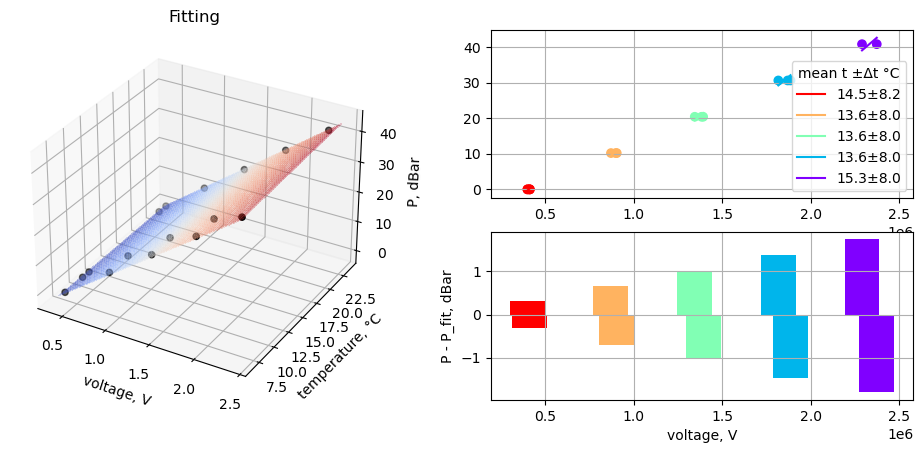

In [50]:
# Show plots 
# %matplotlib inline  # is it realy changes something in juputerlab
fig = plt.figure(figsize=plt.figaspect(0.4))
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 4, sharex=ax2)  # link x axis
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

# Plot result surface
u_min, u_max, t_min, t_max, P_min, P_max = np.min(u), np.max(u), np.min(t), np.max(t), np.min(y), np.max(y)
print('; '.join(f'{var}(min,max): {v1:.3g}, {v2:.3g}' for var, v1, v2 in (('u', u_min, u_max), ('t', t_min, t_max), ('P', P_min, P_max))))
ptp_u, ptp_t = u_max - u_min, t_max - t_min
n = 50
X = np.linspace(u_min - ptp_u/n, u_max + ptp_u/n, n)
Y = np.linspace(t_min - ptp_t/n, t_max + ptp_t/n, n)
X, Y = np.meshgrid(X, Y)
Z_in = np.column_stack((X.ravel(), Y.ravel()))
Z = regr.predict(poly_model.fit_transform(Z_in)).reshape(X.shape)
surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.2)
ax1.scatter3D(*x.values.T, y, color='k')
ax1.set_xlabel('voltage, V')
ax1.set_ylabel('temperature, °C')
ax1.set_zlabel('P, dBar')  # pressure
ax1.set_title('Fitting')

# Plot predictions lines for each sub experiment in assumption that external values changes linear between fitting points
# experiment's colors
c_experiments = cm.rainbow(np.linspace(0, 1, max(i_exp) + 1)[::-1])  # reverse colors if last temp lower
# fitting points
ax2.scatter(x['u'].values, y, c=c_experiments[i_exp])
# predictions
print('Errors of fit for experiments with different mean temperature:')
for i, (c_exp, y_exp) in enumerate(zip(c_experiments, ref_possible)):
    x_exp = x[i_exp==i]
    # print(u_exp, t_exp)
    u_min, t_min, u_max, t_max, t_mean = *x_exp.min(), *x_exp.max(), x_exp['t'].mean()
    # print('u(min,max):', u_min, u_max, 't(min,max):', t_min, t_max)
    X = np.linspace(u_min, u_max , n)
    Y = np.linspace(t_min, t_max , n)
    Z_in = np.column_stack((X, Y))
    Z_in_tr = poly_model.fit_transform(Z_in)
    Z = regr.predict(Z_in_tr)
    Z_check = regr.intercept_ + (regr.coef_ * Z_in_tr).sum(axis=1)
    np.testing.assert_array_equal(Z, Z_check)
    
    ax2.plot(X, Z, color=c_exp, label=f'{t_mean:.1f}±{(t_max - t_min)/2:.1f}')
    
    z_diff = y_exp - regr.predict(poly_model.fit_transform([[u_min, t_min], [u_max, t_max]]))
    print(f'{t_mean:.1f}:', z_diff)

    # ax3.plot([u_min, u_max], z_diff, color=c_exp)
    ax3.bar(x=[u_min, u_max], height=z_diff, width=ptp_u/10, color=c_exp)
    ax3.set_xlabel('voltage, V')
    ax3.set_ylabel('P - P_fit, dBar')
ax2.legend(title='mean t ±Δt °C')
ax2.grid()
ax3.grid()

In [50]:
# Use formula for other data
u = [0.841866, 0.926501, 1.00791, 1.08949, 1.17089, 1.25182]
t = [15.0949, 15.0421, 14.9854, 14.9287, 14.884, 14.8525]
# Atmospheric pressure, dBar:
y_a = 1013/100  # 1008.5 hPa
# Real pressure, dBar:
y = y_a + np.append(0, np.arange(1.045, 1.045*(5 + 0.0001), 1.000))  # *9.80665
z = regr.predict(poly_model.fit_transform(np.column_stack((u, t))))
np.column_stack((y, z, y - z))

In [ ]:
# display fitted polynom formula (not tried)
def join_txt(text,delim='*'):
    return np.asarray(delim.join(text),dtype=object)

if True: 
    variable_names=poly.get_feature_names_out(X.columns)
    variable_names=np.core.defchararray.replace(variable_names.astype(str),' ','*')    

    fit_coeffs=["{:0.5g}".format(x) for x in fit.coef_]

    arr_list=[fit_coeffs,variable_names]
    fit_equation=np.apply_along_axis(join_txt, 0, arr_list)
    fit_equation='+'.join(fit_equation)
    fit_equation=fit_equation.replace("*1+","+")
    fit_equation=fit_equation.replace("+-","-")

    print("Fit equation:")    
    print(fit_equation)

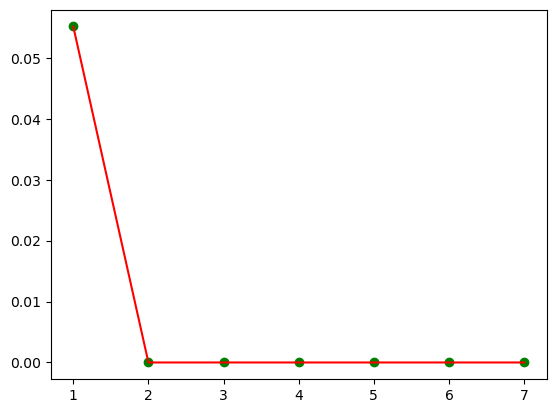

In [46]:
# check our accuracy for each degree, the lower the error the better!
number_degrees = [1,2,3,4,5,6,7]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model = PolynomialFeatures(degree=degree)
  
   poly_x = poly_model.fit_transform(x)
   poly_model.fit(poly_x, y)
  
   regression_model = LinearRegression()
   regression_model.fit(poly_x, y)
   y_pred = regression_model.predict(poly_x)
  
   plt_mean_squared_error.append(mean_squared_error(y, y_pred, squared=False))
  
plt.scatter(number_degrees,plt_mean_squared_error, color="green")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 